# Polyak averaging

Let's try this out. My method for implementing this in TensorFlow started from a blog post here: http://ruishu.io/2017/11/22/ema/ but is updated to work with newer TF versions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

import sklearn.decomposition

%matplotlib inline
from IPython.core.pylabtools import figsize

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.5.0'

## Load the dataset

Let's get MNISTy.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

Edit the `"data/"` to wherever you hid the files.

In [4]:
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [5]:
N = 250
train_images = mnist.train.images[:N,:]
train_labels = mnist.train.labels[:N]

# split into batches
train_image_batches = np.array_split(train_images, 50)
train_label_batches = np.array_split(train_labels, 50)

In [6]:
tf.reset_default_graph()

## Build a model function

I want to make a note here because this is a design pattern we're going to run into more often in the future. A lot of higher-level TensorFlow interfaces (like `tf.estimator`) make use of a `model_fn` that adds all of the model variables to the graph.

By tossing all this in a function we make it really easy to rebuild the graph different ways.

In [7]:
def model_fn(x, getter=None, reuse=False):
    # variable scopes give some control over how TF initializes
    # variables. in this case it'll help us reuse model variables.
    with tf.variable_scope("model", custom_getter=getter, reuse=reuse):
        net = tf.identity(x)
        for _ in range(10):
            net = tf.layers.dense(net, 16, activation=tf.nn.relu)
        return tf.layers.dense(net, 10)

## Build the model

Call `model_fn` to actually build the graph:

In [9]:
x = tf.placeholder(tf.float32, [None, 784])

logits = model_fn(x)

[<tf.Variable 'model/dense/kernel:0' shape=(784, 16) dtype=float32_ref>,
 <tf.Variable 'model/dense/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model/dense_1/kernel:0' shape=(16, 16) dtype=float32_ref>,
 <tf.Variable 'model/dense_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model/dense_2/kernel:0' shape=(16, 16) dtype=float32_ref>,
 <tf.Variable 'model/dense_2/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model/dense_3/kernel:0' shape=(16, 16) dtype=float32_ref>,
 <tf.Variable 'model/dense_3/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model/dense_4/kernel:0' shape=(16, 16) dtype=float32_ref>,
 <tf.Variable 'model/dense_4/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model/dense_5/kernel:0' shape=(16, 16) dtype=float32_ref>,
 <tf.Variable 'model/dense_5/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model/dense_6/kernel:0' shape=(16, 16) dtype=float32_ref>,
 <tf.Variable 'model/dense_6/bias:0' shape=(16,) dtype=float32_ref>,
 <

Let's also get a list of all the trainable variables so far. We'll need this to tell gradient descent to optimize the variables in this model, but not the variables in our exponential-weighted model.

In [ ]:
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
train_vars

## Build the moving average

TensorFlow has a built-in object for computing rolling averages (think about how algorithms like `RMSProp` and `ADAM` work; this is a necessary component for them). We'll create an operation that updates an exponentially-smoothed average of all the trainable variables in our model:

In [10]:
ema = tf.train.ExponentialMovingAverage(decay=0.995)
ema_op = ema.apply(train_vars)

In [11]:
ema_op

<tf.Operation 'ExponentialMovingAverage' type=NoOp>

Here's the part I really wouldn't have come up with on my own. We'll write a "getter" function that adds an extra step when we create a variable- if the variable name is in our `ExponentialMovingAverage` object, it will return the smoothed version; otherwise it returns the original (creating it if necessary):

In [12]:
def ema_getter(getter, name, *args, **kwargs):
    """
    Modified "get" function. Basically return
    the smoothed version of the variable if it's in our
    smoother; otherwise return the original variable
    """
    var = getter(name, *args, **kwargs)
    ema_var = ema.average(var)
    return ema_var if ema_var else var

Now run `model_fn` again, this time with the custom `getter` function- so as it fills out an an identical neural network to the first one we built, it will replace the weights in each layer with exponentially-smoothed versions:

In [13]:
logits_ema = model_fn(x, getter=ema_getter, reuse=True)

Now build out all the training components- note we're only training the original model (look at `optimizer.minimize`), but want to do predictions (so we can compute accuracy) on the smoothed version as well:

In [14]:
y = tf.placeholder(tf.int32, [None,])
y_oh = tf.one_hot(y, 10)

loss = tf.losses.softmax_cross_entropy(y_oh, logits)
optimizer = tf.train.MomentumOptimizer(1e-3, 0.9)
train_op = optimizer.minimize(loss, var_list=train_vars)

predictions = tf.argmax(logits, 1, output_type=tf.int32)
predictions_ema = tf.argmax(logits_ema, 1, output_type=tf.int32)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y, predictions), tf.float32))
accuracy_ema = tf.reduce_mean(tf.cast(tf.equal(y, predictions_ema), tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Training loop

Here's pseudocode for what we're doing:

1. Start a TensorFlow session
2. Initialize all the variables
3. For each epoch:
  * For each training batch:
    * update the model weights with `train_op`
    * update the moving average with `ema_op`
  * Compute test accuracies with the model and moving-average model

In [15]:
acc = []
acc_ema = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in tqdm(range(150)):
        for im, lab in zip(train_image_batches, train_label_batches):
            _ = sess.run([train_op,ema_op], feed_dict={x:im, y:lab})
            
        fd = {x:mnist.test.images, y:mnist.test.labels}
        acc.append(sess.run(accuracy, feed_dict=fd))
        acc_ema.append(sess.run(accuracy_ema, feed_dict=fd))

100%|██████████| 150/150 [00:16<00:00,  9.12it/s]


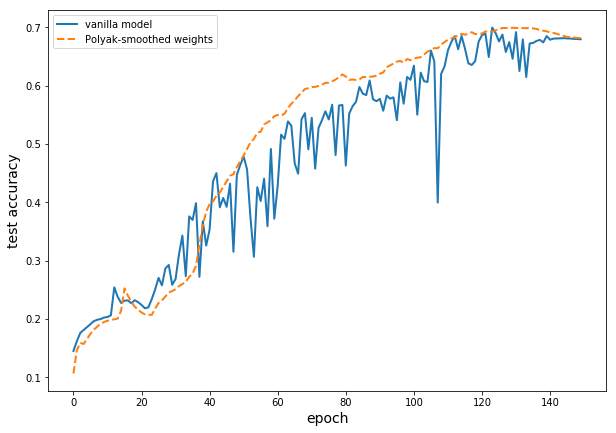

In [17]:
figsize(10, 7)
plt.plot(acc, lw=2, label="vanilla model")
plt.plot(acc_ema, "--", lw=2, label="Polyak-smoothed weights")
plt.xlabel("epoch", fontsize=14)
plt.ylabel("test accuracy", fontsize=14)
plt.legend(loc="upper left");